# Model Predictive Control Rocket Soft-Landing Problem

This notebook is a walkthough of the ALTRO solver for the MPC Rocket Soft-Landing Problem (i.e. the general control challenge of landing a rocket at rest at a designated landing site). In the simplest case, we treat the rocket as a sphere landing on a flat surface with no atmosphere. This approximation is reasonable when the rocket is near the ground and entering the final part of the descent.

**This files focuses on the MPC problem and comparing the result to other solvers. For the simple (non-MPC) application and set-up explanation, please visit the <code>RocketLandingSOCP-SetupExplained.ipynb</code> file. Thanks!**

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

 Activating environment at `C:\Users\Daniel N\.julia\dev\altro-mpc-icra2021\benchmarks\rocket_landing\Project.toml`


## MPC Problem Outline

For the MPC application, we must fulfill two critical steps:
- [x] Solve the optimal trajectory and apply the required controls (usually a short horizon)
- [x] Use the prior trajectory to warm-start the next solve

In this Jupyter notebook, we will:
1. Set up the rocket soft-landing problem
    - Model Dynamics
    - Discretization
    - Specify the Disturbance (e.g. wind) separate from model dynamics
    - Initial and Final States
2. Solve the initial trajectory optimization problem (cold-start)
    - Solve the full trajectory
3. Solve the realtime trajectory optimization problem (warm-start, shorter horizon)
    - Solve the shorter trajectory
    - Execute the control (and propagate forward in time)
    - Warm-Start the next iteration
    - Solve the next shorter horizon trajectory optimization problem
    - Repeat above steps until arrival at the landing location

# Step 1: Set-Up the Rocket Soft-Landing Problem

## Load Required Packages

The <code>RobotDynamics</code> package enables us to define the rocket model and dynamics. The <code>TrajectoryOptimization</code> and <code>Altro</code> set-up and solve the trajectory optimization problem. <code>StaticArrays</code> and <code>LinearAlgebra</code> are required to set-up the appropriate data types.

Next, <code>Plots, MeshCat, TrajOptPlots, FileIO,</code> and <code>MeshIO</code> packages are used to visualize the results. Note that the plotting sections will take significantly longer to run than the optimization. 

Lastly, <code>DifferentialEquations</code> integrates the dynamics forward as a way to show that the dynamics constraints are satisfied.

Loading all the packages, especially for plotting and the differential equations integrator can be the longest part of the whole notebook.

In [2]:
using RobotDynamics
import RobotDynamics: dynamics
using Rotations
using Altro
using TrajectoryOptimization
using StaticArrays, LinearAlgebra
println("Trajectory Optimization Packages Ready")

# using Plots
# pyplot()
# println("Base Plotting Packages Ready")

# using MeshCat, TrajOptPlots
# using FileIO, MeshIO
# println("3D Plotting Packages Ready")

import DifferentialEquations.solve, DifferentialEquations.ODEProblem, DifferentialEquations.Tsit5
using BenchmarkTools
println("Differential Equations Ready")

Trajectory Optimization Packages Ready
Differential Equations Ready


In [3]:
using Plots
pyplot()
println("Base Plotting Packages Ready")

Base Plotting Packages Ready


Add second-order cone constraints

In [4]:
include("general_socp.jl")
println("Added more general SOCP Constraint")

Added more general SOCP Constraint


## Detail the Rocket Dynamics

For the simplified rocket problem, we choose to ignore the attitude dynamics. Applying newton's second law or by forming a Lagrangian, we arrive at the following sparse linear system

$$\frac{dx}{dt} = Ax + Bu + g$$

Where $A = \begin{bmatrix}0 & I\\ 0 & 0 \end{bmatrix}$, $B = \begin{bmatrix}0 \\ \frac{1}{m} I\end{bmatrix}$, and $G = \begin{bmatrix} 0 \\ -g \end{bmatrix}$. For the 3D case, these are $(6 \times 6)$, $(6 \times 3)$, and $(6 \times 1)$ matricies, respectively. 

In [5]:
const mass = 10.0
const grav = SA[0.0; 0.0; -9.81]

model = LinearModel([zeros(3,3) I; zeros(3, 6)], [zeros(3,3); (1/mass) * I], vec([zeros(3, 1); grav]))

struct Rocket
    m
    g
    model
end

## Instantiate the Model and Define the Discretization

Feel free to choose <code>N</code> and <code>tf</code> based on your needs.

In [6]:
rocket = Rocket(mass, grav, model)
n, m = size(rocket.model)

# Trajectory Discretization
N = 301
tf = 10.
dt = tf/(N-1)

rocket # (Simply for information) Display the struct as the cell output 

Rocket(10.0, [0.0, 0.0, -9.81], LinearModel{6,3,Float64,15}(SizedArray{Tuple{6,6},Float64,2,2}[[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 1.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]], SizedArray{Tuple{6,3},Float64,2,2}[[0.0 0.0 0.0; 0.0 0.0 0.0; … ; 0.0 0.1 0.0; 0.0 0.0 0.1]], SizedArray{Tuple{6},Float64,1,1}[[0.0, 0.0, 0.0, 0.0, 0.0, -9.81]], Float64[], 0.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], true))

## Detail the Full Dynamics (With Distrubance)

In Matlab, we would use ODE 45, but in the <code>DifferentialEquations.jl</code> package we can either (1) just let the <code>solve</code> method figure it out or (2) specify a solver such as <code>Tsit5</code>, which should handle any ODE that a fourth-order Runge Kutta Method could handle.

In [32]:
"Disturbance"
function wind(y, p, t)
    return [zeros(3); 0; 0.1; 0]
end

"Disturbance"
function no_wind(y, p, t)
    return zeros(6)
end

"Full Dynamics Model"
function full_model(r::Rocket, x0, dt::Float64, controlsArr, disturbance; num_timesteps::Int64 = 3, t0::Float64 = 0.0)
    # Zero-Order Hold
    get_controls(t) = controlsArr[min(Int(floor(t/dt)) + 1, size(controlsArr,1))]
    # Full Dynamics
    f(y,p,t) = dynamics(r.model, y, get_controls(t)) + disturbance(y, p, t)

    tspan = (t0, t0 + dt * num_timesteps)
    controls_p0 = get_controls(t0)

    # Use the DifferentialEquations.jl Package
    ode_prob = ODEProblem(f, x0, tspan, controls_p0)
    ode_sol = solve(ode_prob, Tsit5(), reltol=1e-10, abstol=1e-10);
    
    return ode_sol
end

full_model

## Specify the Initial and Final Conditions

Choose the initial and final points. Note that these must be full state vectors ($[x; y; z; v_x; v_y; v_z]$). The initial point is generally the rocket's current state. The final point is generally the rocket's landing stop. Note that the final velocity of the rocket should **always** be $[0.0; 0.0; 0.0]$ to have a **soft** landing.

In [8]:
# Initial and Final Conditions
rocketStart = @SVector [4.0, 2.0, 20.0, -3.0, 2.0, -5.0] # Start at a 20 m altitude with an ~15 m/s plummet
rocketEnd = @SVector zeros(n);  # Swing pendulum up and end at rest

# Step 2: Solve Cold Start Trajectory

In [9]:
# Helper function for Max Thrust Constraint
function getAlpha(theta, deg = true)
    if deg
        return tand(theta)
    end
    return tan(theta)
end

#=
Solve the trajectory optimization problem from current location to the final landing spot.

Returns the benchmark data and the optimized solve
=#
function ColdStartFull(r::Rocket, x0, xf, N, opts; 
                        Qk::Float64 = 1.0e-2, Qfk::Float64 = 100.0, Rk::Float64 = 1.0e-1, 
                        ground_level::Float64 = 0.0, theta_max_deg::Float64 = 7.0, perWeightMax::Float64 = 2.0,
                        includeGoal::Bool = true, verbose::Bool = true)
    n, m = size(r.model)
    
    # Set-UP the LQR Objective Function
    Q = Qk * Diagonal(@SVector ones(n))
    Qf = Qfk * Diagonal(@SVector ones(n))
    R = Rk * Diagonal(@SVector ones(m))
    obj = LQRObjective(Q,R,Qf,xf,N)
    if verbose
        println("Objective Set")
    end
    
    # Create Empty ConstraintList
    conSet = ConstraintList(n,m,N)
    
    if includeGoal
        # Goal Constraint that the rocket must reach the landing site.
        goal = GoalConstraint(xf)
        add_constraint!(conSet, goal, N)
        if verbose
            println("Goal Constraint Set")
        end
    end
    
    # Bound Constraint that the rocket doesn't crash into the ground
    # This constraint can be made more complicated for difficult terrain
    # This constraint can also be a glidescope constraint.
    bnd = BoundConstraint(n,m, x_min=[-Inf, -Inf, ground_level,
                                      -Inf, -Inf, -Inf])
    if verbose
        println("Ground Constraint Set")
    end
    
    # Norm Constrant that reflects the max thrust the rocket can provide
    u_bnd = r.m * norm(r.g[3]) * perWeightMax
    maxT = NormConstraint(n, m, u_bnd, TrajectoryOptimization.SecondOrderCone(), :control)
    add_constraint!(conSet, maxT, 1:N-1)
    if verbose
        println("Max Thrust Constraint Set")
    end

    # Generalized Norm Constraint that reflects the max thrust angle constraint
    # Based on the rocket gimbal
    maxTAalpha = getAlpha(theta_max_deg)
    ARocket = SizedMatrix{3,3}([1.0 0 0; 0 1.0 0; 0 0 0])
    cRocket = SVector{3}([0; 0; maxTAalpha])
    maxTA = NormConstraint2(n, m, ARocket, cRocket, TrajectoryOptimization.SecondOrderCone(), :control)
    add_constraint!(conSet, maxTA, 1:N-1)
    if verbose
        println("Max Thrust Angle Constraint Set")
    end
    
    # Package the objective and constraints into a "problem" type
    prob = Problem(model, obj, xf, tf, x0=x0, constraints=conSet)
    if verbose
        println("Problem Packaged")
    end
    
    # Set the initial controls to a hover
    u0 = r.g # controls that would nominally hover
    U0 = [u0 for k = 1:N-1] # vector of the small controls
    initial_controls!(prob, U0)
    rollout!(prob)
    if verbose
        println("Set Initial Controls")
    end
    
    altro = ALTROSolver(prob, opts)
    if verbose
        println("Set Solver and Options")
    end
    
    println("Prepping benchmark solve")
    set_options!(altro, show_summary=false)
    b = benchmark_solve!(altro)
    println("Benchmark solve")
    
    println("Prepping solve with summary")
    set_options!(altro, show_summary=true)
    solve!(altro);
    println("Solve Complete")
    
    return b, altro
end

ColdStartFull (generic function with 1 method)

In [10]:
opts = SolverOptions(
        cost_tolerance_intermediate=1e-2,
        penalty_scaling=10.,
        penalty_initial=1.0,
        verbose = 1,
        projected_newton = false,
        constraint_tolerance = 1.0e-8
    )

b, altro_solve = ColdStartFull(rocket, rocketStart, rocketEnd, N, opts)

X_cold = states(altro_solve)
U_cold = controls(altro_solve);

Objective Set
Goal Constraint Set
Ground Constraint Set
Max Thrust Constraint Set
Max Thrust Angle Constraint Set
Problem Packaged
Set Initial Controls
Set Solver and Options
Prepping benchmark solve
Benchmark solve
Prepping solve with summary

SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 15
    Solve Time: 81.994 (ms)

  Covergence
    Terminal Cost: 5343.056256730129
    Terminal dJ: 8.639304229741356
    Terminal gradient: 0.009207225432861923
    Terminal constraint violation: 4.651521919377122e-11
    Solve Status: SOLVE_SUCCEEDED
Solve Complete


In [11]:
b

BenchmarkTools.Trial: 
  memory estimate:  95.30 MiB
  allocs estimate:  684371
  --------------
  minimum time:     79.125 ms (11.60% GC)
  median time:      80.496 ms (11.56% GC)
  mean time:        80.806 ms (11.49% GC)
  maximum time:     83.390 ms (10.99% GC)
  --------------
  samples:          7
  evals/sample:     10

### Visualize the Reference Trajectory

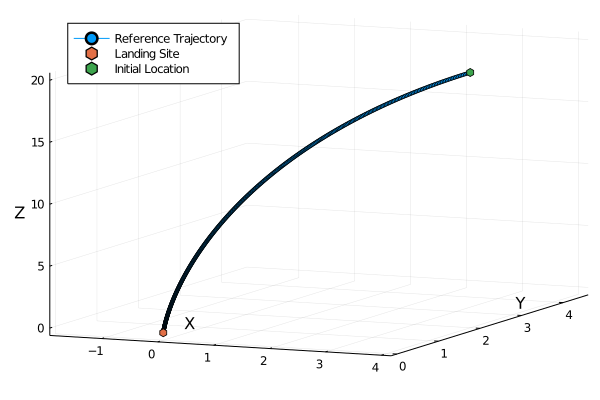

In [12]:
function get_arr_at_ind(arr, ind)
    return [x[ind] for x in arr]
end

gr()
plot3d(get_arr_at_ind(X_cold, 1), get_arr_at_ind(X_cold, 2), get_arr_at_ind(X_cold, 3), 
    markershape = :circle, markersize = 2, label = "Reference Trajectory", xlabel = "X", ylabel = "Y", zlabel = "Z",
    legend = :topleft)
scatter!([rocketEnd[1]], [rocketEnd[2]], [rocketEnd[3]], markershape = :hexagon, label = "Landing Site")
scatter!([rocketStart[1]], [rocketStart[2]], [rocketStart[3]], markershape = :hexagon, label = "Initial Location")

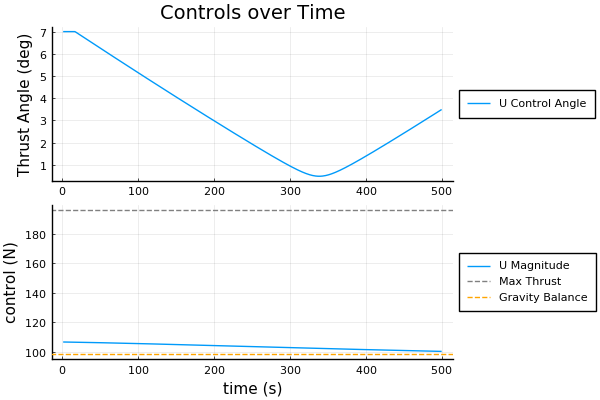

In [13]:
function getAngle3D(u)
    if norm(u[3]) == 0.0
        # hit the tan singularity
        return pi / 2
    else
        return atand(norm([u[1]; u[2]]), u[3])
    end
end

function get_angle_xy(u)
    return atand(u[2], u[1])
end

pyplot()

plt_ux = plot(getAngle3D.(U_cold), label = "U Control Angle", legend = :outerright)
# hline!([-ulateral_max, ulateral_max], linecolor = :grey, linestyle = :dash,
#                 label = "Max Lateral Thrust")
# xlabel!("time (s)")
ylabel!("Thrust Angle (deg)")
title!("Controls over Time")

plt_umag = plot(norm.(U_cold), label = "U Magnitude", legend = :outerright)
hline!([2 * norm(mass * grav[3])], linecolor = :grey, linestyle = :dash, label = "Max Thrust")
hline!([norm(mass * grav[3])], linecolor = :orange, linestyle = :dash, label = "Gravity Balance")
xlabel!("time (s)")
ylabel!("control (N)")

plt_u = plot(plt_ux, plt_umag, layout = (2, 1))

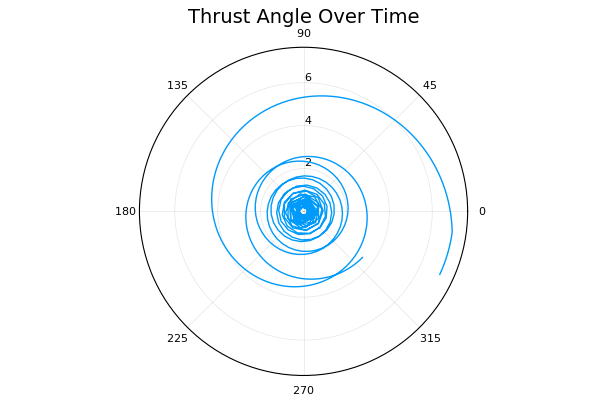

In [14]:
theta = get_angle_xy.(U_cold)
rad = getAngle3D.(U_cold)

plot(theta, rad, proj = :polar, legend = :none, title = "Thrust Angle Over Time")

# Step 3: Solve Warm-Start and Model the Rocket Descent

In [15]:
#=
Solve the trajectory optimization problem from current location to the final landing spot.

Returns the benchmark data and the optimized solve
=#
function MPC_SetUp(r::Rocket, x0, xf, horizon; 
                        Qk::Float64 = 1.0e-2, Rk::Float64 = 1.0e-1, 
                        ground_level::Float64 = 0.0, theta_max_deg::Float64 = 7.0, 
                        perWeightMax::Float64 = 2.0, verbose::Bool = true)
    n, m = size(r.model)
    
    # Set-UP the LQR Objective Function
    Q = Qk * Diagonal(@SVector ones(n))
    R = Rk * Diagonal(@SVector ones(m))
    
#     obj = Objective(QuadraticCost(Q, R), horizon)
    obj = LQRObjective(Q,R,Q,xf,horizon)
    
    if verbose
        println("Objective Set")
    end
    
    # Create Empty ConstraintList
    conSet = ConstraintList(n, m, horizon)
    
    # Bound Constraint that the rocket doesn't crash into the ground
    # This constraint can be made more complicated for difficult terrain
    # This constraint can also be a glidescope constraint.
    bnd = BoundConstraint(n,m, x_min=[-Inf, -Inf, ground_level,
                                      -Inf, -Inf, -Inf])
    if verbose
        println("Ground Constraint Set")
    end
    
    # Norm Constrant that reflects the max thrust the rocket can provide
    u_bnd = r.m * norm(r.g[3]) * perWeightMax
    maxT = NormConstraint(n, m, u_bnd, TrajectoryOptimization.SecondOrderCone(), :control)
    add_constraint!(conSet, maxT, 1:horizon-1)
    if verbose
        println("Max Thrust Constraint Set")
    end

    # Generalized Norm Constraint that reflects the max thrust angle constraint
    # Based on the rocket gimbal
    maxTAalpha = getAlpha(theta_max_deg)
    ARocket = SizedMatrix{3,3}([1.0 0 0; 0 1.0 0; 0 0 0])
    cRocket = SVector{3}([0; 0; maxTAalpha])
    maxTA = NormConstraint2(n, m, ARocket, cRocket, TrajectoryOptimization.SecondOrderCone(), :control)
    add_constraint!(conSet, maxTA, 1:horizon-1)
    if verbose
        println("Max Thrust Angle Constraint Set")
    end
    
    # Goal Constraint that the rocket must reach the landing site.
    goal = GoalConstraint(xf)
    add_constraint!(conSet, goal, horizon)
    if verbose
        println("Goal Constraint Set")
    end
    
    return obj, conSet
end

MPC_SetUp (generic function with 1 method)

In [16]:
function changeGoal!(c::ConstraintList, xf_new::SArray{Tuple{6},Float64,1,6})
    @assert typeof(c.constraints[end]) == GoalConstraint{6, Float64}
    c.constraints[end] = GoalConstraint(xf_new)
    
    return nothing
end


# Array{TrajectoryOptimization.AbstractConstraint,1}

function changeGoal!(p::Problem, xf_new::SArray{Tuple{6},Float64,1,6})
    return changeGoal!(p.constraints, xf_new)
end

function warmstart_problem(r::Rocket, obj::Objective, cset::ConstraintList, warm_states, warm_controls, tf)
    
    prob = Problem(r.model, obj, warm_states[end], tf, x0=warm_states[1], constraints=cset)
    
    initial_controls!(prob, warm_controls)
    initial_states!(prob, warm_states)
    rollout!(prob)
    
    return prob
end

function MPC_Solve(prob::Problem, opts; summary::Bool = false)
    altro = ALTROSolver(prob, opts)
    
    set_options!(altro, show_summary=false)
    b = benchmark_solve!(altro)
    
    set_options!(altro, show_summary=summary)
    solve!(altro);
    
    return b, altro
end

MPC_Solve (generic function with 1 method)

Execute the MPC forward until landed

In [41]:
# # Initial Conditions
# x_curr = rocketStart # Current state (x, v)
# u_curr = [U_cold[1]] # Controls (u) applied at this instant
# t_curr = 0.0 # Start time
# num_tsteps = 1 # Number of steps to propogate the physics
# hor = 100 # length of the MPC horizon in number of steps

# o, c = MPC_SetUp(rocket, rocketStart, rocketEnd, hor, theta_max_deg = 10.0);

# opts = SolverOptions(
#         cost_tolerance_intermediate=1e-2,
#         penalty_scaling=10.,
#         penalty_initial=10.0,
#         verbose = 1,
#         projected_newton = false,
#         reset_duals = false
#     )

# # Propagate the physics forward to the next timestep
# updated_model = full_model(rocket, x_curr, dt, u_curr, no_wind, num_timesteps = num_tsteps, t0 = t_curr)

# # Grab the time and state
# t_curr = updated_model.t[end]
# x_curr = updated_model.u[end]

# # We expect roughly the zero except in the direction of the wind
# display(x_curr - X_cold[2])

# # Grab a new target based on the reference trajectory
# x_target = X_cold[hor]
# changeGoal!(c, x_target)

# # Construct the warm-started state and control arrays
# X_warm = [[x_curr]; X_cold[3:hor + 1]]
# U_warm = U_cold[2:hor+1]

# # Construct the Problem
# p = warmstart_problem(rocket, o, c, X_warm, U_warm, dt * hor)

# # Solve the next iteration
# b, altro_mpc = MPC_Solve(p, opts)
# display(b)

# # Grab the new optimized trajectory
# X_new = states(altro_mpc)
# U_new = controls(altro_mpc)

# # Propagate the physics forward to the next timestep
# updated_model = full_model(rocket, x_curr, dt, u_curr, no_wind, num_timesteps = num_tsteps, t0 = t_curr)

# # Grab the time and state
# t_curr = updated_model.t[end]
# x_curr = updated_model.u[end]

# # We expect roughly the zero except in the direction of the wind
# display(x_curr - X_new[3])
# display(x_curr - X_cold[3])

In [29]:
# gr()
# plot3d(get_arr_at_ind(X_cold, 1), get_arr_at_ind(X_cold, 2), get_arr_at_ind(X_cold, 3), 
#     label = "Reference Trajectory", legend = :outerright)
# plot3d!(get_arr_at_ind(X_cold[1:hor], 1), get_arr_at_ind(X_cold[1:hor], 2), get_arr_at_ind(X_cold[1:hor], 3), 
#     markershape = :circle, label = "Reference Trajectory")
# plot3d!(get_arr_at_ind(X_new, 1), get_arr_at_ind(X_new, 2), get_arr_at_ind(X_new, 3), markershape = :circle, 
#     label = "MPC Trajectory")


In [30]:
# pyplot()

# plot(norm.(X_cold[1:hor] - X_new), xlabel = "Time Step", ylabel = "Error", legend = :none, 
#         title = "Deviation between \n Reference Trajectory and MPC Trajectory")

In [31]:
# pyplot()

# plt_ux = plot(getAngle3D.(U_new), label = "U Control Angle", legend = :bottomright)
# # hline!([-ulateral_max, ulateral_max], linecolor = :grey, linestyle = :dash,
# #                 label = "Max Lateral Thrust")
# # xlabel!("time (s)")
# ylabel!("Thrust Angle (deg)")
# title!("Controls over Time")

# plt_umag = plot(norm.(U_new), label = "U Magnitude")
# hline!([2 * norm(mass * grav[3])], linecolor = :grey, linestyle = :dash, label = "Max Thrust")
# hline!([norm(mass * grav[3])], linecolor = :orange, linestyle = :dash, label = "Gravity Balance")
# xlabel!("time (s)")
# ylabel!("control (N)")

# plt_u = plot(plt_ux, plt_umag, layout = (2, 1))

In [ ]:
# Initial Conditions
x_curr = rocketStart # Current state (x, v)
u_curr = [U_cold[1]] # Controls (u) applied at this instant
t_curr = 0.0 # Start time
num_tsteps = 1 # Number of steps to propogate the physics
hor = 100 # length of the MPC horizon in number of steps

o, c = MPC_SetUp(rocket, rocketStart, rocketEnd, hor, theta_max_deg = 10.0);

benchmark_arr = []
MPC_Iteration_States = []

# If Desired
# MPC_Controls = []
# MPC_Trajectories = []

println()

num_iters = N - hor

for iter in 1:num_iters
    # Propagate the physics forward to the next timestep
    updated_model = full_model(rocket, x_curr, dt, u_curr, no_wind, num_timesteps = num_tsteps, t0 = t_curr)

    # Grab the time and state
    t_curr = updated_model.t[end]
    x_curr = updated_model.u[end]
    
    push!(MPC_Iteration_States, x_curr)

    # We expect roughly the zero except in the direction of the wind
#     display(x_curr - X_cold[2])

    # Grab a new target based on the reference trajectory
    x_target = X_cold[hor]
    changeGoal!(c, x_target)

    # Construct the warm-started state and control arrays
    X_warm = [[x_curr]; X_cold[2 + iter:hor + iter]]
    U_warm = U_cold[1 + iter:hor + iter]

    # Construct the Problem
    p = warmstart_problem(rocket, o, c, X_warm, U_warm, dt * hor)

    # Solve the next iteration
    b, altro_mpc = MPC_Solve(p, opts)
    push!(benchmark_arr, b)

    # Grab the new optimized trajectory
    X_new = states(altro_mpc)
    U_new = controls(altro_mpc)
    u_curr = [U_new[1]]
    
#     push!(MPC_Trajectories, X_new)
#     push!(MPC_Controls, U_new)
    
    print("Iter = $iter @ Violation = $(TrajectoryOptimization.max_violation(altro_mpc))")
    println(" & Median Time = $(round(median(b.times) / 1e6, digits=2)) ms")
end

Objective Set
Ground Constraint Set
Max Thrust Constraint Set
Max Thrust Angle Constraint Set
Goal Constraint Set

Iter = 1 @ Violation = 9.451740803356756e-7 & Median Time = 2.25 ms
Iter = 2 @ Violation = 9.232583062512845e-7 & Median Time = 2.19 ms
Iter = 3 @ Violation = 9.019202233950807e-7 & Median Time = 2.18 ms
Iter = 4 @ Violation = 8.811497611560526e-7 & Median Time = 2.95 ms
Iter = 5 @ Violation = 8.609368626899538e-7 & Median Time = 2.22 ms
Iter = 6 @ Violation = 8.412715990502306e-7 & Median Time = 2.99 ms
Iter = 7 @ Violation = 8.22144026191296e-7 & Median Time = 2.92 ms
Iter = 8 @ Violation = 8.03544371485998e-7 & Median Time = 2.23 ms
Iter = 9 @ Violation = 7.854628649717199e-7 & Median Time = 2.95 ms
Iter = 10 @ Violation = 7.678898072960294e-7 & Median Time = 3.01 ms
Iter = 11 @ Violation = 8.028319924413552e-7 & Median Time = 2.31 ms
Iter = 12 @ Violation = 7.850981567081305e-7 & Median Time = 3.3 ms
Iter = 13 @ Violation = 7.678774718300474e-7 & Median Time = 3.16 ms


Iter = 121 @ Violation = 49.47491241181593 & Median Time = 1.34 ms
Iter = 122 @ Violation = 46.13400067437773 & Median Time = 1.26 ms
Iter = 123 @ Violation = 31.563818169457996 & Median Time = 1.41 ms
Iter = 124 @ Violation = 35.39304099201717 & Median Time = 1.41 ms
Iter = 125 @ Violation = 17.858333915904648 & Median Time = 1.42 ms
Iter = 126 @ Violation = 361.9268700871046 & Median Time = 1.05 ms
Iter = 127 @ Violation = 18.430464807612616 & Median Time = 1.24 ms
Iter = 128 @ Violation = 18.83135416839124 & Median Time = 0.87 ms
Iter = 129 @ Violation = 19.11406715433519 & Median Time = 1.2 ms
Iter = 130 @ Violation = 49.28664237207807 & Median Time = 1.44 ms
Iter = 131 @ Violation = 46.22485808767523 & Median Time = 1.79 ms
Iter = 132 @ Violation = 49.31158178025444 & Median Time = 1.45 ms
Iter = 133 @ Violation = 50.8450092457655 & Median Time = 1.41 ms
Iter = 134 @ Violation = 44.70608824229154 & Median Time = 2.1 ms
Iter = 135 @ Violation = 55.19965556700714 & Median Time = 1.4

Iter = 244 @ Violation = 163.12132547786226 & Median Time = 1.32 ms
Iter = 245 @ Violation = 495.9443400505266 & Median Time = 1.5 ms
Iter = 246 @ Violation = 344.2341693595234 & Median Time = 1.31 ms
Iter = 247 @ Violation = 143.51960518258758 & Median Time = 1.3 ms
Iter = 248 @ Violation = 238.31505246682624 & Median Time = 1.66 ms
Iter = 249 @ Violation = 214.31222722761746 & Median Time = 1.37 ms
Iter = 250 @ Violation = 78.19004604109118 & Median Time = 2.03 ms
Iter = 251 @ Violation = 70.60421399074151 & Median Time = 1.2 ms
Iter = 252 @ Violation = 133.96740978099632 & Median Time = 1.84 ms
Iter = 253 @ Violation = 61.818055587123105 & Median Time = 1.27 ms
Iter = 254 @ Violation = 70.92928683005867 & Median Time = 1.26 ms
Iter = 255 @ Violation = 64.38517613484571 & Median Time = 1.65 ms
Iter = 256 @ Violation = 151.03645671544157 & Median Time = 1.58 ms
Iter = 257 @ Violation = 77.32695572486213 & Median Time = 1.22 ms
Iter = 258 @ Violation = 159.0142408638762 & Median Time =

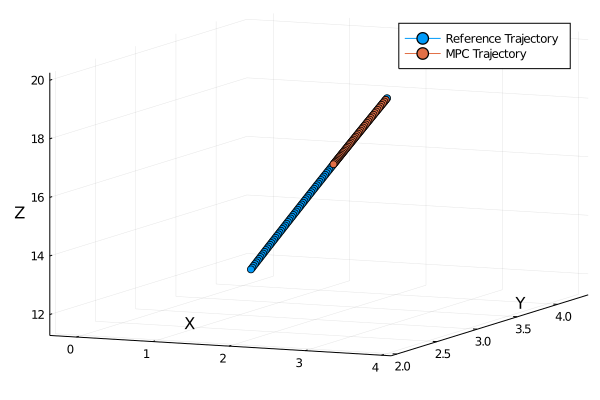

In [43]:
gr()
plot3d(get_arr_at_ind(X_cold[1:hor], 1), get_arr_at_ind(X_cold[1:hor], 2), get_arr_at_ind(X_cold[1:hor], 3), 
    markershape = :circle, label = "Reference Trajectory", xlabel = "X", ylabel = "Y", zlabel = "Z")
plot3d!(get_arr_at_ind(MPC_Iteration_States, 1), get_arr_at_ind(MPC_Iteration_States, 2), 
            get_arr_at_ind(MPC_Iteration_States, 3), 
            markershape = :circle, label = "MPC Trajectory")

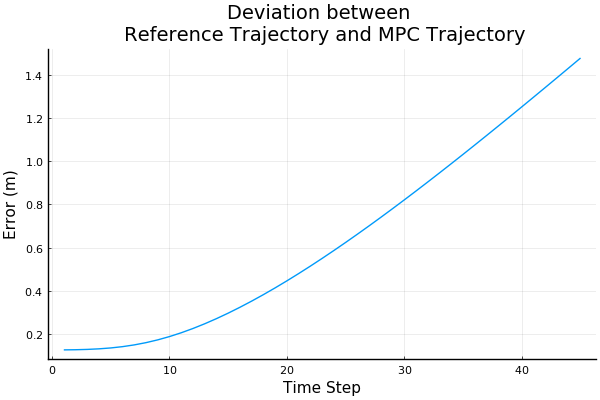

In [44]:
pyplot()

plot(norm.(X_cold[1:length(MPC_Iteration_States)] - MPC_Iteration_States), 
        xlabel = "Time Step", ylabel = "Error (m)", legend = :none, 
        title = "Deviation between \n Reference Trajectory and MPC Trajectory")

## Lastly, let's visualize the results in 3D with Meshcat

To do this, we need to provide a Mesh to <code>MeshCat</code>. This is due with <code>FileIO</code> and <code>MeshIO</code>.

In [25]:
# vis = Visualizer() # Creates a MeshCat Window
# render(vis) # Renders the window below

In [26]:
# function TrajOptPlots._set_mesh!(vis, model::Rocket)
#     obj = joinpath(@__DIR__, "SimpleRocket.obj")
#     quad_scaling = 0.085
#     robot_obj = FileIO.load(obj)
#     robot_obj.vertices .*= quad_scaling
#     mat = MeshPhongMaterial(color=colorant"lightgrey")
#     setobject!(vis["geom"], robot_obj, mat)
# end

# TrajOptPlots.set_mesh!(vis, model)

In [27]:
# Base.position(::Rocket, x::StaticVector) = SA[x[1], x[2], x[3]]
# RobotDynamics.orientation(::Rocket, x::StaticVector) = UnitQuaternion(0,0,0,1)

# visualize!(vis, altro);